# Sources of misinformation

In [36]:
import utils

import pandas as pd
import numpy as np
from os.path import join
import seaborn as sns
import re

import requests
import os
import json
import matplotlib.pyplot as plt
from tqdm.contrib.concurrent import thread_map

## Read and clean raw domain lists

See [this doc](https://docs.google.com/document/d/1UN9HQCCWYHIk2b0vc26KlsdczSzyMQ5hapyr30iW5uw/edit#) for a more detailed description of the sources.

In [37]:
src  = '../resources/domains/raw'

In [ ]:
fname = 'columbia_journalism_review_tags_2021-04.csv'
domains = pd.read_csv(join(src, fname))

In [ ]:
clean_domains = pd.DataFrame()
for index, row in domains.iterrows():
    tags = row['tags'].split(', ')
    domains = domains.drop(index)
    for tag in tags:
        clean_domains = clean_domains.append({
            'url':row['domain'],
            'label':tag,
            'rank':row['rank']
        }, ignore_index=True)

In [ ]:
clean_domains.to_csv(join(src, 'columbia_journalism_review_2021-04.csv'))

### Read the raw domain lists from various sources

In [38]:
# source/author : latest update
sources = {'bufale':'2018',
           'bufalopedia':'2020-05-05',
           'butac':'2021-05-18',
           'buzzfeed':'2017-08-08',
           'columbia_journalism_review':'2021-04',
           'fake_news_watch':'2016-01-18',
           'girnberg':'2019-01-28',
           'media_bias_fact_check':'2021-05-17',
           'politifact':'2017-11-09',
           'zimdars':'2016'}

In [39]:
domain_list = pd.DataFrame()
for source, updated in sources.items():
    fname = '{}_{}.csv'.format(source, updated)
    print(fname)
    tmp = pd.read_csv(join(src, fname), usecols=['url', 'label'])
    tmp['source'] = source
    tmp['last_update'] = updated
    domain_list = pd.concat([domain_list, tmp])
domain_list = domain_list.reset_index(drop=True)
domain_list.head(3)

bufale_2018.csv
bufalopedia_2020-05-05.csv
butac_2021-05-18.csv
buzzfeed_2017-08-08.csv
columbia_journalism_review_2021-04.csv
fake_news_watch_2016-01-18.csv
girnberg_2019-01-28.csv
media_bias_fact_check_2021-05-17.csv
politifact_2017-11-09.csv
zimdars_2016.csv


,url,label,source,last_update
0,http://notiziepericolose.blogspot.it/,false satire,bufale,2018
1,http://www.ilmattoquotidiano.it/,false satire,bufale,2018
2,http://www.ilmessaggio.it/,false satire,bufale,2018


Read Newsguard domains

In [40]:
newsguard = pd.read_csv(join(src, 'newsguard_2021-09-30.csv')).rename(columns={
    'Domain': 'url',
    'Does not repeatedly publish false content': "c1", 
    'Gathers and presents information responsibly': "c2", 
    'Regularly corrects or clarifies errors': "c3", 
    'Handles the difference between news and opinion responsibly': "c4", 
    'Avoids deceptive headlines': "c5",
    "Website discloses ownership and financing": "t1",
    "Clearly labels advertising": "t2",
    "Reveals who's in charge, including any possible conflicts of interest": "t3",
    "The site provides names of content creators, along with either contact or biographical information": "t4"
})
newsguard = newsguard[["url", "Rating", "c1", "c2", "c3" ,"c4", "c5", "t1", "t2", "t3", "t4"]]
newsguard = newsguard.query("Rating != 'P'")
newsguard["source"] = "newsguard"
newsguard["last_update"] = "2021-09-30"
newsguard.head()

,url,Rating,c1,c2,c3,c4,c5,t1,t2,t3,t4,source,last_update
0,arabnews.com,N,Yes,No,No,No,Yes,No,Yes,Yes,No,newsguard,2021-09-30
1,thewashingtonstandard.com,N,No,No,No,No,No,Yes,No,Yes,Yes,newsguard,2021-09-30
2,sports.whatfinger.com,N,No,No,No,No,No,No,No,No,No,newsguard,2021-09-30
3,scitech.whatfinger.com,N,No,No,No,No,No,No,No,No,No,newsguard,2021-09-30
4,money.whatfinger.com,N,No,No,No,No,No,No,No,No,No,newsguard,2021-09-30


In [41]:
domain_list = pd.concat([domain_list, newsguard])

### Sanitize domains

In [42]:
domain_list = domain_list.dropna(subset=['url']).reset_index(drop=True)

In [43]:
# Handlabel all domains not matching an URL
# r"[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)" (adjusted from https://regexr.com/37i6s)
dict_records = pd.read_csv(join(src, "../missing_urls.csv")).to_dict(orient="records")
domain_list["url"] = domain_list["url"].replace({record["entry"]: record["url"] for record in dict_records})

In [44]:
domain_list['url'] = domain_list['url'].apply(utils.clean_url)

In [45]:
domain_list

,url,label,source,last_update,Rating,c1,c2,c3,c4,c5,t1,t2,t3,t4
0,notiziepericolose.blogspot.it,false satire,bufale,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ilmattoquotidiano.it,false satire,bufale,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ilmessaggio.it,false satire,bufale,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ilfattoquotidaino.it,false satire,bufale,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ilquotidaino.wordpress.com,false satire,bufale,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14738,telegraph.co.uk,NaN,newsguard,2021-09-30,T,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,No
14739,standard.co.uk,NaN,newsguard,2021-09-30,T,Yes,Yes,Yes,Yes,Yes,No,No,No,No
14740,iltempo.it,NaN,newsguard,2021-09-30,T,Yes,Yes,No,No,Yes,No,Yes,Yes,No
14741,iltempo.it,NaN,newsguard,2021-09-30,T,Yes,Yes,No,No,Yes,No,Yes,Yes,No


In [46]:
domain_list.head()

,url,label,source,last_update,Rating,c1,c2,c3,c4,c5,t1,t2,t3,t4
0,notiziepericolose.blogspot.it,false satire,bufale,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ilmattoquotidiano.it,false satire,bufale,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ilmessaggio.it,false satire,bufale,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ilfattoquotidaino.it,false satire,bufale,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ilquotidaino.wordpress.com,false satire,bufale,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


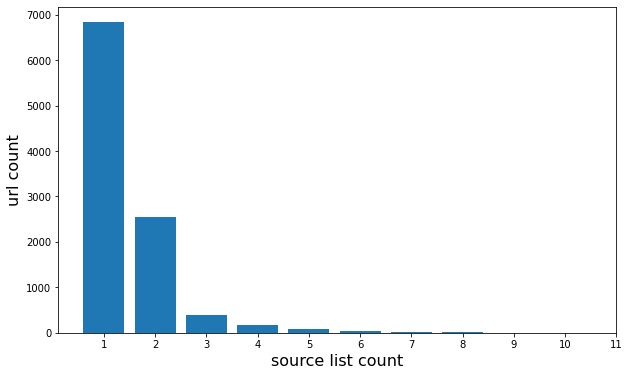

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))
list_count = domain_list['url'].value_counts()
ax.hist(list_count, rwidth=0.8, align='left',
        bins=range(1, list_count.max() + 1))
ax.set_ylabel('url count', fontsize=16)
ax.set_xlabel('source list count', fontsize=16)
ax.set_xticks(range(1, list_count.max() + 1));

### Map labels to accuracy/transparency scores and reliability types

We came up with two scores to unify different labelling scales.

### Accuracy
The accuracy score relates to the credibility or tells how fact-based the news outlet reports. It ranges from 1 (no accuracy) to 5 (high accuracy).

| Label      	        | Score 	| Description                                                                 	|    Type    	|
|-------------------	|:-----:	|-----------------------------------------------------------------------------	|:----------:	|
| False information  	|   1   	| No or very little accuracy (e.g. fake news, conspiracy, satire)             	| Unreliable 	|
| Clickbait  	        |   2   	| News with some truthness or facts, but actually misleading (e.g. clickbait) 	| Unreliable 	|
| Biased     	        |   3   	| Mixed accuracy, hide/report half of the truth (e.g. bias, state)            	|  Reliable  	|
| Mainstream 	        |   4   	| Low bias/mainstream media (e.g. center right/left bias)                     	|  Reliable  	|
| Scientific 	        |   5   	| No bias/scientific news                                                     	|  Reliable  	|

### Transparency
The transparency score rates for instance how open/honest the news outlet is about telling the truth or not. It also includes a news source’s intention for fact-based reportage.

| Label              	| Score 	| Description                                                                                                                                         	|    Type    	|
|--------------------	|:-----:	|-----------------------------------------------------------------------------------------------------------------------------------------------------	|:----------:	|
| No Transparency    	|   1   	| Intentionally misleading or no information about editorial process (e.g. fake news, conspiracy)                                                     	| Unreliable 	|
| Mixed Transparency 	|   2   	| Sites with (partially) transparent intention, but can still be misunderstood because of the way articles are written (e.g. bias, clickbait, satire) 	|  Reliable  	|
| Transparent        	|   3   	| Sites with transparent editorial or legal notice (e.g. mainstream, scientific news)                                                                 	|  Reliable  	|

In [48]:
new_labels = pd.read_csv("../resources/labels.csv").sort_values(by="label")
new_labels = new_labels.drop_duplicates().dropna()
new_labels[["accuracy", "transparency"]] = new_labels[["accuracy", "transparency"]].astype(int)
new_labels

,label,accuracy,transparency
42,Fake news,1,1
41,Imposter site,1,1
43,Parody site,1,2
44,Some fake stories,2,1
22,bias,3,2
35,center right bias,4,3
51,clickbait,2,2
12,close to Qanon,1,1
47,conspiracy,1,1
19,conspiracy blogs,1,1


In [49]:
# Remove domains with Zimdars label "hate" or "unknown"
# source == 'Zimdars' & (label == 'hate' | label == 'unknown')
domain_list = domain_list.query("source != 'zimdars' | (label != 'hate' & label != 'unknown')")

In [50]:
domain_list["label"] = domain_list["label"].str.lower()
new_labels["label"] = new_labels["label"].str.lower()
labeled_domains = domain_list.merge(new_labels, on="label", how="outer")

/home/vrupp/misinformation_tools/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Handle newsguard domains

In [51]:
def get_newsguard_accuracy(df):
    series = pd.Series([-1] * df.shape[0], index=df.index)
    series[(series == -1) & (df["Rating"] == "S")] = 1
    
    series[(series == -1) & (df[["c1", "c2", "c3", "c4", "c5"]] == "Yes").all(axis=1)] = 5
    series[(series == -1) & (df[["c1", "c2"]] == "Yes").all(axis=1) & ((df[["c3", "c4", "c5"]] == "Yes").sum(axis=1) == 2)] = 4
    series[(series == -1) & (df["c1"] == "Yes") & ((df[["c2", "c3", "c4", "c5"]] == "Yes").sum(axis=1) >= 2)] = 3
    series[(series == -1) & ((df[["c1", "c2", "c3", "c4", "c5"]] == "Yes").sum(axis=1) == 2)] = 2
    series[(series == -1) & ((df[["c1", "c2", "c3", "c4", "c5"]] == "Yes").sum(axis=1) <= 1)] = 1
    
    return series

def get_newsguard_transparency(df):
    n_yes = (df[["t1", "t2", "t3", "t4"]] == "Yes").sum(axis=1)
    series = pd.Series([-1] * df.shape[0], index=df.index)
    series[(series == -1) & (df["Rating"] == "S")] = 2

    series[(series == -1) & (n_yes <= 1)] = 1
    series[(series == -1) & (n_yes <= 3)] = 2
    series[(series == -1) & (n_yes == 4)] = 3
    return series

newsguard = labeled_domains.query("source == 'newsguard'")
labeled_domains.loc[newsguard.index, "accuracy"] = get_newsguard_accuracy(newsguard)
labeled_domains.loc[newsguard.index, "transparency"] = get_newsguard_transparency(newsguard)
labeled_domains = labeled_domains.drop(columns=["Rating"])

In [52]:
assert labeled_domains[["accuracy", "transparency"]].isna().any().any() == False

In [53]:
labeled_domains[["accuracy", "transparency"]] = labeled_domains[["accuracy", "transparency"]].astype(int)
labeled_domains = labeled_domains.drop(columns=["c1", "c2", "c3", "c4", "c5", "t1", "t2", "t3", "t4"])

### Drop hard duplicates

Drop domains that have the same harm score across all their source lists

In [54]:
print('{}/{} are hard duplicates'.format(\
    len(labeled_domains) - len(labeled_domains.drop_duplicates(subset=['url', 'accuracy', 'transparency'])), 
    len(labeled_domains)))

3276/15139 are hard duplicates


In [55]:
labeled_domains = labeled_domains.drop_duplicates(subset=['url', 'accuracy', 'transparency'])

### Drop soft duplicates, keep lowest accuracy/transparency score

In [56]:
print('{}/{} are soft duplicates'.format(\
    len(labeled_domains) - len(labeled_domains['url'].unique()), 
    len(labeled_domains)))

1892/11863 are soft duplicates


In [57]:
domain_counts = labeled_domains['url'].value_counts()
soft_duplicates = domain_counts[domain_counts > 1].index

In [58]:
labeled_domains[labeled_domains['url'] == 'madworldnews.com'].sort_values(by=["accuracy", "transparency"])

,url,label,source,last_update,accuracy,transparency
999,madworldnews.com,fake news,girnberg,2019-01-28,1,1
10794,madworldnews.com,NaN,newsguard,2021-09-30,1,3
3991,madworldnews.com,unreliable,columbia_journalism_review,2021-04,2,1
126,madworldnews.com,clickbait,columbia_journalism_review,2021-04,2,2
3098,madworldnews.com,right bias,buzzfeed,2017-08-08,3,2


In [59]:
for sd in soft_duplicates:
    sd_domains = labeled_domains[labeled_domains['url'] == sd].sort_values(by=["accuracy", "transparency"])
    labeled_domains = labeled_domains.drop(sd_domains.index[1:])    # Keep only row with minimum accuracy and transparency
labeled_domains = labeled_domains.reset_index(drop=True)

In [60]:
assert len(labeled_domains) == len(labeled_domains['url'].unique())

In [61]:
print('there are {} unique domains left'.format(len(labeled_domains)))

there are 9971 unique domains left


### Filter Active Domains

In [27]:
status_codes = thread_map(utils.check_url_status, domain_list, max_workers=os.cpu_count() * 4)
status_codes = pd.DataFrame(status_codes)
status_codes.to_csv("../resources/domains/clean/domain_status_codes.csv", index=False)

  0%|          | 0/14546 [00:00<?, ?it/s]

In [62]:
status_codes = pd.read_csv("../resources/domains/clean/domain_status_codes.csv")
status_codes.head()

,url,full_url,status_code,redirected
0,notiziepericolose.blogspot.it,https://notiziepericolose.blogspot.it,200,False
1,ilmattoquotidiano.it,https://ilmattoquotidiano.it,200,False
2,ilmessaggio.it,https://ilmessaggio.it,200,False
3,ilfattoquotidaino.it,http://ilfattoquotidaino.it,200,False
4,ilquotidaino.wordpress.com,https://ilquotidaino.wordpress.com,200,False


In [63]:
status_codes = labeled_domains.merge(status_codes[["url", "status_code"]], on="url")[["accuracy", "transparency", "status_code"]]
status_codes["status"] = np.where(status_codes["status_code"] == 200, "active", "inactive")
status_codes.head()

,accuracy,transparency,status_code,status
0,1,1,200,active
1,1,1,200,active
2,1,1,200,active
3,1,1,200,active
4,1,1,200,active


### Assign types and filter domains for disinformation

In [64]:
labeled_domains['type'] = np.where((labeled_domains["accuracy"] < 3) & (labeled_domains["transparency"] < 2), "unreliable", "reliable")
labeled_domains["accuracy_bin"] = np.where(labeled_domains["accuracy"] <= 3, "inaccurate", "accurate")
status_codes["type"] = np.where((status_codes["accuracy"] < 3) & (status_codes["transparency"] < 2), "unreliable", "reliable")

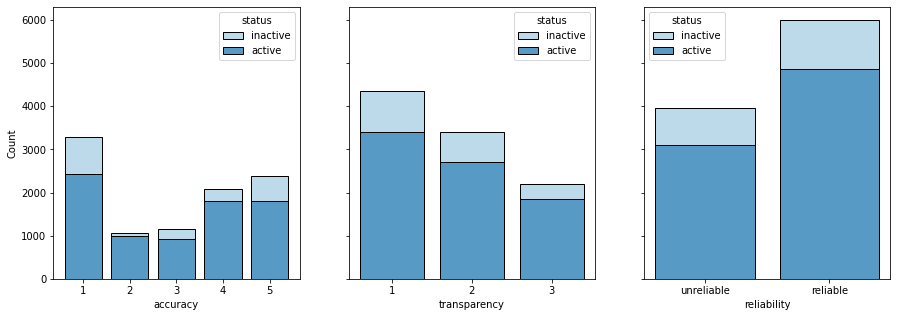

In [65]:
status_codes = status_codes.astype(str)
hue_order = ["inactive", "active"]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
sns.histplot(data=status_codes, x="accuracy", hue="status", palette="Paired", multiple="stack", hue_order=hue_order, shrink=0.8, ax=ax[0])
ax[0].set_xlabel("accuracy")
sns.histplot(data=status_codes, x="transparency", hue="status", palette="Paired", multiple="stack", hue_order=hue_order, shrink=0.8, ax=ax[1])
ax[1].set_xlabel("transparency")
sns.histplot(data=status_codes, x="type", hue="status", palette="Paired", multiple="stack", hue_order=hue_order, shrink=0.8, ax=ax[2])
ax[2].set_xlabel("reliability")
fig.savefig("../plots/domains/label-distributions.pdf", bbox_inches="tight")

In [66]:
(status_codes["status_code"] == "200").sum()

7957

In [67]:
labeled_domains['type'].value_counts()

reliable      6002
unreliable    3969
Name: type, dtype: int64

For comparison, the [Galotti 2020 et al.](https://www.nature.com/articles/s41562-020-00994-6/tables/1) category counts: 
* unreliable: 2264
* reliable: 1434
* unknown: 194

In [68]:
labeled_domains.to_csv('../resources/domains/clean/domain_list_clean.csv', index=False)

In [69]:
labeled_domains[labeled_domains['type'] == 'unreliable'].to_csv(\
        '../resources/domains/clean/unreliable_domains_clean.csv', index=False)